## Prerequisite Packages

In [30]:
# Based on https://www.tensorflow.org/datasets/keras_example
# use pip install <package> to find any packages that are missing
import keras  # for fitting DNNs
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, RepeatVector, Dropout
from keras.utils import plot_model
import pydotplus, pydot
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pydot

## Extracting data

In [2]:
# data from: www.manythings.org/anki/
# define training data
data = pd.read_csv('../data/deu.txt', sep='\t', header=None).iloc[:, [0, 1]]
data.columns = ['english', 'german']

# shuffling
data = data.sample(frac=1)
train_pct = 0.8

# words begin with "\t" and end with "\n"
data['english'] = [['\t']+line.replace('.', '').replace('!', '').replace(
    '?', '').split(' ')+['\n'] for line in data['english'].values]
data['german'] = [['\t']+line.replace('.', '').replace('!', '').replace(
    '?', '').split(' ')+['\n'] for line in data['german'].values]

## Training and testing data

In [3]:
# train data
train_data = data.iloc[:int(train_pct*len(data)), ]

# train model
embedding_eng = Word2Vec(train_data['english'].values, size=300, min_count=1)
embedding_it = Word2Vec(train_data['german'].values, size=300, min_count=1)
# np.max([len(sentence) for sentence in train_data['english'].values])
max_sent_eng = 5
# np.max([len(sentence) for sentence in train_data['german'].values])
max_sent_it = 5
# embedding using training data-based model
train_data['english_emb'] = [[embedding_eng[word] for word in sentence] if len(
    sentence) <= max_sent_eng else np.nan for sentence in train_data['english'].values]
train_data['german_emb'] = [[embedding_it[word] for word in sentence] if len(
    sentence) <= max_sent_it else np.nan for sentence in train_data['german'].values]
train_data = train_data.dropna()
train_data['english_emb'] = [sentence+[embedding_eng['\n']] *
                             (max_sent_eng-len(sentence)) for sentence in train_data['english_emb'].values]
train_data['german_emb'] = [sentence+[embedding_it['\n']] *
                            (max_sent_it-len(sentence)) for sentence in train_data['german_emb'].values]


test_data = data.iloc[int(train_pct*len(data)):, ].reset_index(drop=True)
test_data['english_emb'] = [[embedding_eng[word] for word in sentence if word in embedding_eng.wv.vocab]
                            for sentence in test_data['english'].values]
test_data['german_emb'] = [[embedding_it[word] for word in sentence if word in embedding_it.wv.vocab]
                           for sentence in test_data['german'].values]
test_data = test_data.loc[[len(line['english']) <= max_sent_eng and len(
    line['german']) <= max_sent_it for n, line in test_data.iterrows()], ]
# remove data if words not in embedding method
test_data = test_data.loc[[len(line['english']) == len(line['english_emb']) and len(
    line['german']) == len(line['german_emb']) for n, line in test_data.iterrows()], ]
test_data['english_emb'] = [sentence+[embedding_eng['\n']] *
                            (max_sent_eng-len(sentence)) for sentence in test_data['english_emb'].values]
test_data['german_emb'] = [sentence+[embedding_it['\n']] *
                           (max_sent_it-len(sentence)) for sentence in test_data['german_emb'].values]

C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

## Plotting embedded training data

## Embedding demonstrates that translation is a transformation of word embeddings, but not a trivial mapping!

C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


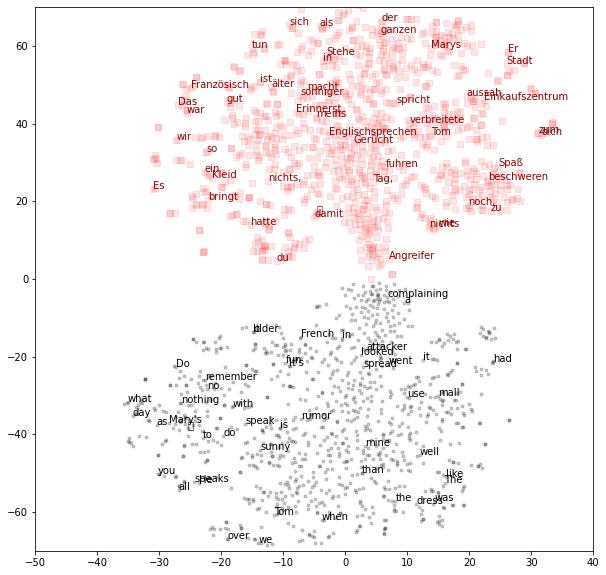

In [4]:

# ['Hi!', 'Run!', 'Who?', 'Jump.', 'Stay.', 'Go', 'ran.', 'see.', 'try.']#list(embedding_eng.wv.vocab)[:20]
eng_words = list(embedding_eng.wv.vocab)[:1000]
# ["Ciao!", "Corri!", "Chi?", "Salta.", "Resta.", "Vai", "corri", "vedi", "prova"]
it_words = list(embedding_it.wv.vocab)[:1000]
#print("Ciao!" in embedding_it.wv.vocab)
tsne = TSNE(n_components=2)
result = tsne.fit_transform(np.concatenate(
    (embedding_it[it_words], embedding_eng[eng_words])))
result_eng = result[:len(eng_words)]  # tsne.fit_transform()
result_it = result[len(eng_words):]
# create a scatter plot of the projection
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.scatter(result_eng[:, 0], result_eng[:, 1],
            color='k', marker='.', alpha=0.2)
plt.scatter(result_it[:, 0], result_it[:, 1], color='r', marker='s', alpha=0.1)
plt.ylim([-70, 70])
plt.xlim([-50, 40])
for i, word in enumerate(it_words[:50]):
    plt.annotate(word, xy=(result_it[i, 0], result_it[i, 1]), color='darkred')
for i, word in enumerate(eng_words[:50]):
    plt.annotate(word, xy=(result_eng[i, 0], result_eng[i, 1]), color='k')
plt.show()

## Translation Model

### Training Model

QUIZ 9 q4:
Explore how to adjust the model such that it has accuracy > 5\%, measured in terms of translating some sentences in the test dataset perfectly. You cannot remove any test data other than sentences longer than 5 words. 

In [7]:
# num of features?
embedding_dim = 300  # reworked backwartds by dividing seq_in by num samples and num timesteps

In [8]:
# Based on: https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
max_data = -1  # 10000
# define input sequence
# array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
seq_in = train_data["english_emb"].values[:max_data]
seq_in = np.array([np.array(line) for line in seq_in])

# reshape input into [samples, timesteps, features]
seq_in = seq_in.reshape((len(seq_in), max_sent_eng, embedding_dim))

# prepare output sequence
seq_out = train_data["german_emb"].values[:max_data]  # seq_in[:, 1:,:]
seq_out = np.array([np.array(line) for line in seq_out])

# max words in italial sentences
n_out = max_sent_it

## Original model
# define model
model = Sequential()
model.add(LSTM(30, activation="relu", input_shape=(max_sent_eng, embedding_dim)))
model.add(RepeatVector(n_out))
model.add(LSTM(30, activation="relu", return_sequences=True))
model.add(TimeDistributed(Dense(embedding_dim)))
model.compile(optimizer="adam", loss="mse")

# fit model
model.fit(seq_in, seq_out, epochs=300, verbose=0)

In [44]:
## Adjusted model for Quiz 9
model = Sequential()

# ============================================================
## Add layers one by one:

# Add LSTM layer
model.add(LSTM(30, activation="relu", input_shape=(max_sent_eng, embedding_dim)))

model.add(Dropout(0.2))

# Repeat the input n_out times
model.add(RepeatVector(n_out))

model.add(LSTM(30, activation="relu", return_sequences=True))

model.add(Dropout(0.2))

# Apply a Densely connected layer to every temporal slice of the 3d input
model.add(TimeDistributed(Dense(embedding_dim)))

# ============================================================
# stop training when metric improved
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

# Build model
model.compile(optimizer="adam", loss="mse")

# fit model
history = model.fit(seq_in, seq_out, epochs=800, verbose=0, callbacks=callback)

print(len(history.history['loss']))

37


### Testing Model

In [45]:
def get_sentence(embeddings, language):
    if language == "english":
        return (
            " ".join(
                [
                    embedding_eng.most_similar(positive=[emb], topn=1)[0][0]
                    for emb in embeddings
                ]
            )
            .replace("\n", "")
            .replace("\t", "")
        )
    elif language == "german":
        return (
            " ".join(
                [
                    embedding_it.most_similar(positive=[emb], topn=1)[0][0]
                    for emb in embeddings
                ]
            )
            .replace("\n", "")
            .replace("\t", "")
        )

In [ ]:
max_data_test = 2000

# print(test_data)
seq_in_test = test_data["english_emb"].values[:max_data_test]
seq_in_test = np.array([np.array(line) for line in seq_in_test])
seq_out_test = test_data["german_emb"].values[:max_data_test]
seq_out_test = np.array([np.array(line) for line in seq_out_test])

yhat = model.predict(seq_in_test, verbose=0)

## Print random sentence and its translation (actual and predicted)
# index = np.random.randint(0, high=max_data_test)
# print("English:\t", get_sentence(seq_in_test[index], "english"))
# print("True german:\t", get_sentence(seq_out_test[index], "german"))
# print("Translation:\t", get_sentence(yhat[index], "german"))


# Quiz 9 - measure accuracy in terms of translating % sentences correctly
## calculate % correct out of % total as accuracy

total, correct = max_data_test, 0

for i in range(total):
    pred = get_sentence(yhat[i], "german")
    actual = get_sentence(seq_out_test[i], "german")
    if pred == actual:  ## if perfect translation
        correct += 1

C:\Users\erica\anaconda3\envs\dsci552\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


In [ ]:
acc = float(correct) / float(total)
print(f"Accuracy: {acc}")   ## goal is greater than 5%

### Even when model is wrong, it is kind of right, i.e., the translation usually gives us qualitatively similar meanings

In [257]:

plot_model(model, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Another example: predicting data 2 timesteps out

In [ ]:
# taken from: https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/

# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_pair(n_in, n_out, cardinality):
	# generate random sequence
	sequence_in = generate_sequence(n_in, cardinality)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	X = one_hot_encode(sequence_in, cardinality)
	y = one_hot_encode(sequence_out, cardinality)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))
	return X,y

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2
# define model
model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps_in, n_features)))
model.add(RepeatVector(n_timesteps_in))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(n_features, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# train LSTM
for epoch in range(5000):
	# generate new random sequence
	X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
	# fit model for one epoch on this sequence
	model.fit(X, y, epochs=1, verbose=0)
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
	X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
	yhat = model.predict(X, verbose=0)
	if array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
		correct += 1


In [123]:
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))
# spot check some examples
for _ in range(10):
	X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
	yhat = model.predict(X, verbose=0)
	print('Expected:', one_hot_decode(y[0]), 'Predicted', one_hot_decode(yhat[0]))


Accuracy: 19.00%
Expected: [41, 8, 0, 0, 0] Predicted [41, 41, 0, 0, 0]
Expected: [1, 45, 0, 0, 0] Predicted [1, 45, 0, 0, 0]
Expected: [40, 30, 0, 0, 0] Predicted [40, 12, 0, 0, 0]
Expected: [40, 21, 0, 0, 0] Predicted [40, 21, 0, 0, 0]
Expected: [20, 24, 0, 0, 0] Predicted [20, 20, 0, 0, 0]
Expected: [47, 19, 0, 0, 0] Predicted [47, 47, 0, 0, 0]
Expected: [19, 25, 0, 0, 0] Predicted [19, 19, 0, 0, 0]
Expected: [31, 18, 0, 0, 0] Predicted [31, 18, 0, 0, 0]
Expected: [5, 28, 0, 0, 0] Predicted [5, 29, 0, 0, 0]
Expected: [38, 39, 0, 0, 0] Predicted [38, 38, 0, 0, 0]
